# Heritability Estimation Dev Notebook

In [1]:
import copy

from pheno_sim import PhenoSimulation

In [2]:
def gen_config(heritability=1.0):
	"""Return linear additive model config with specified heritability."""
	return {
		"input": [
			{
				"file": "1000_genomes_data/ALL.chr19.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz",
				"file_format": "vcf",
				"reference_genome": "GRCh37",
				"force_bgz": True,
				"input_nodes": [
					{
						"alias": "rare_variants",
						"type": "SNP",
						"chr": "19",
						"pos": [13397324, 52901080, 16023111]
					},
					{
						"alias": "common_variants",
						"type": "SNP",
						"chr": "19",
						"pos": [55555845, 55261043, 45857820, 55442280, 39369369]
					}
				]
			}
		],
		"simulation_steps": [
			{
				"type": "RandomConstant",
				"alias": "rare_variants_betas",
				"input_match_size": "rare_variants",
				"dist_name": "normal",
				"dist_kwargs": {
					"loc": 0.0,
					"scale": 0.5
				},
				"by_feat": True
			},
			{
				"type": "RandomConstant",
				"alias": "common_variants_betas",
				"input_match_size": "common_variants",
				"dist_name": "normal",
				"dist_kwargs": {
					"loc": 0.0,
					"scale": 0.2
				},
				"by_feat": True
			},
			{
				"type": "Product",
				"alias": "rare_variant_effects",
				"input_aliases": [
					"rare_variants_betas", "rare_variants"
				]
			},
			{
				"type": "Product",
				"alias": "common_variant_effects",
				"input_aliases": [
					"common_variants_betas", "common_variants"
				]
			},
			{
				"type": "Concatenate",
				"alias": "variant_effects",
				"input_aliases": [
					"rare_variant_effects", "common_variant_effects"
				],
			},
			{
				"type": "AdditiveCombine",
				"alias": "combined_variant_effects",
				"input_alias": "variant_effects"
			},
			{
				"type": "SumReduce",
				"alias": "no_noise_phenotype",
				"input_alias": "combined_variant_effects"
			},
			{
				"type": "Heritability",
				"alias": "phenotype",
				"input_alias": "no_noise_phenotype",
				"heritability": heritability
			}
		]
	}


In [3]:
sim = PhenoSimulation(gen_config())
input_vals = sim.run_input_step()

Initializing Hail with default parameters...


Loading input data...


SLF4J: No SLF4J providers were found.
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See https://www.slf4j.org/codes.html#noProviders for further details.
SLF4J: Class path contains SLF4J bindings targeting slf4j-api versions 1.7.x or earlier.
SLF4J: Ignoring binding found at [jar:file:/Users/ross/miniforge3/envs/pheno_sim/lib/python3.10/site-packages/pyspark/jars/log4j-slf4j-impl-2.17.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See https://www.slf4j.org/codes.html#ignoredBindings for an explanation.
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.3.2
SparkUI available at http://100.84.25.81:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.118-a4ca239602bb
LOGGING: writing to /Users/ross/Desktop/gwas/CITRUS/doc/example_nbs/hail-20230808-1310-0.2.118-a4ca239602bb.log
2023-08-08 1

## Estimating heritability

This evaluates multiple related approaches for estimating the broad-sense heritability (H^2) of a CITRUS simulated phenotype. In the following equations $Var(P)$ is the phenotypic variance, $Var(G)$ is the genetic variance, and $Var(E)$ is the environmental variance of the trait.

Broad sense heritability is definied as:

$$ H^2 = \frac{Var(G)}{Var(P)} $$

The phenotypic variance is defined as ([See here for more detail](https://si.biostat.washington.edu/sites/default/files/modules/SISG_Heritability.pdf)):

$$ Var(P) = Var(G) + Var(E) + 2Cov(G,E) $$

In CITRUS simulations, the genetic and environmental effects are independant (no gene x environment interactions), so $Cov(G,E) = 0$ and the phenotypic variance is simply:

$$ Var(P) = Var(G) + Var(E) $$

All approaches for estimation use these equations and share most of the steps. They just differ on how they estimate $Var(P)$ (Step 2 below) and $Var(G)$ (Step 4 below). This results in six slightly different approaches for estimating $H^2$.

### Steps:

1. Simulate phenotype for $n$ individuals $r$ times.

2. Estimate $Var(P)$ using either:

	- The variance of all simulated phenotypes.

	- A bootstrap estimate of the variance by repeatedly sampling one phenotype from each genotype group and finding the overall variance (one sampled phenotype per individual). The estimate is the mean of these sample variances.

3. Find expected $Var(E)$ using the mean of intra-genotype phenotype variances.

	Let $Var(P_i)$ be the variance of the phenotype for genotype $i$. Let $Var(G_i)$ be the variance of the genotype for genotype $i$. We assume $Var(G_i) = 0$, or that in the absence of noise the genotype is deterministic (which is true for CITRUS).

	$$ Var(P_i) = Var(G_i) + E[Var(E_i)] $$
	$$ E[Var(E)] = Mean(Var(P_i))|_{i \in n} $$

4. Estimate $Var(G)$ using either:

	- The difference between $Var(P)$ and $Var(E)$. $Var(P)$ can be estimated using either of the methods in step 2.

	$$ Var(G) = Var(P) - E[Var(E)] $$

	- The variance of the mean of the simulated phenotypes for each genotype. Using the mean value for each genotype is like removing the expected noise E component from the phenotype variance.

	$$ Var(G) = Var(\{Mean(P_i)|_{i \in n}\}) $$

5. Compute heritability estimate as:

	$$ H^2 = \frac{Var(G)}{Var(P)} $$

In [4]:
import numpy as np


def estimate_heritability(
		sim,
		input_vals=None,
		n_replicates: int = 100,
		n_samples=1.0,
		n_bootstrap=1000,
		phenotype_alias='phenotype'
	):
		"""Estimate broad-sense heritability (H^2) of the phenotype.

		Args:
			sim: The simulation object.
			input_vals (default None): A ValuesDict containing the input
				values. If None, will run the input step of the simulation.
			n_replicates (default 100): The number of replicates of each
				genotype to simulate.
			n_samples (default 1.0): The fraction or number of samples to
				use when estimating heritability. If value is less than or
				equal to 1, will use that fraction of samples. If value is
				greater than 1, will use that number of samples. Samples
				will be randomly selected from the input samples.
			n_bootstrap (int, default 1000): The number of bootstrap samples
				to use when estimating the variance of the phenotype and
				genotype.
			phenotype_alias (default 'phenotype'): The alias of the
				phenotype node to use when estimating heritability.

		Returns:
			Tuple with heritability estimated:
				(using between group genotype variance, using sample variance)
		"""

		assert n_replicates >= 2, "n_replicates must be greater than 1."

		# Get input genotype values.
		if input_vals is None:
			input_vals = sim.run_input_step()

		# Get number of sample in input.
		input_item = input_vals[list(input_vals.keys())[0]]
		if isinstance(input_item, tuple):
			n_input_samples = input_item[0].shape[-1]
		else:
			n_input_samples = input_item.shape[-1]

		if n_samples > 1:
			selected_idx = np.random.choice(
				n_input_samples,
				n_samples,
				replace=False
			)
			
			for key, val in input_vals.items():
				if isinstance(val, tuple):
					input_vals[key] = (
						val[0][..., selected_idx], val[1][..., selected_idx]
					)
				else:
					input_vals[key] = val[..., selected_idx]
		elif n_samples < 1:
			selected_idx = np.random.choice(
				n_input_samples,
				int(n_samples * n_input_samples),
				replace=False
			)
			
			for key, val in input_vals.items():
				if isinstance(val, tuple):
					input_vals[key] = (
						val[0][..., selected_idx], val[1][..., selected_idx]
					)
				else:
					input_vals[key] = val[..., selected_idx]
		
		# Estimate heritability.

		# Step 1: Run simulation n_replicates times.
		pheno_vals = []

		for i in range(n_replicates):
			pheno_vals.append(
				sim.run_simulation_steps(
					copy.deepcopy(input_vals)
				)[phenotype_alias]
			)

		# Convert to matrix where rows are replicates and columns are samples.
		pheno_vals = np.vstack(pheno_vals).astype(float)

		# Step 2: Compute total variance.
		# overall
		total_var_overall = np.var(pheno_vals)

		# resampled estimate
		# Sample one value per row n times
		rand_idx = np.random.randint(
			pheno_vals.shape[0], 
			size=(n_bootstrap, pheno_vals.shape[1])
		)
		total_var_resampled = pheno_vals[
			rand_idx, np.arange(pheno_vals.shape[1])
		].var(1).mean()

		# print(total_var_overall, total_var_resampled)

		# Step 3: Compute E[Var(E)] with average intra-genotype variance
		intra_geno_var = np.var(pheno_vals, axis=0).mean()

		# Step 4: Compute inter-genotype variance (the variance of the mean
		# phenotype for each genotype).
		var_g_diff_a = total_var_overall - intra_geno_var
		var_g_diff_r = total_var_resampled - intra_geno_var
		var_g_mean = np.var(np.mean(pheno_vals, axis=0))

		# Step 5: Compute heritability
		return {
			'all_difference_a': var_g_diff_a / total_var_overall,
			'all_difference_r': var_g_diff_r / total_var_overall,
			'all_mean': var_g_mean / total_var_overall,
			'resampled_difference_a': var_g_diff_a / total_var_resampled,
			'resampled_difference_r': var_g_diff_r / total_var_resampled,
			'resampled_mean': var_g_mean / total_var_resampled,
		}

In [5]:
estimate_heritability(sim, copy.deepcopy(input_vals))

{'all_difference_a': 1.0,
 'all_difference_r': 1.0,
 'all_mean': 0.9999999999999998,
 'resampled_difference_a': 1.0,
 'resampled_difference_r': 1.0,
 'resampled_mean': 0.9999999999999998}

## Plot estimates vs true values

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [7]:
# Generate estimates for a range of heritabilities

n_herits = 100
est_results = []

for h2 in tqdm(np.linspace(0.0, 1.0, n_herits)):
    est_h2 = estimate_heritability(
        PhenoSimulation(gen_config(heritability=h2)),
        copy.deepcopy(input_vals),
	)
    est_results.append({
        "heritability": h2,
        **est_h2,
    })

100%|██████████| 100/100 [00:29<00:00,  3.39it/s]


In [8]:
# Convert to a DataFrame
df = pd.DataFrame(est_results)

In [9]:
melt_df = df.copy()
melt_df['true_heritability'] = melt_df['heritability']

melt_df = melt_df.melt(
    id_vars=['heritability'],
    value_vars=melt_df.columns.tolist(),
    var_name='Heritability Measure',
    value_name='value'
)
melt_df

,heritability,Heritability Measure,value
0,0.000000,all_difference_a,0.009584
1,0.010101,all_difference_a,0.019655
2,0.020202,all_difference_a,0.028565
3,0.030303,all_difference_a,0.038769
4,0.040404,all_difference_a,0.050347
...,...,...,...
695,0.959596,true_heritability,0.959596
696,0.969697,true_heritability,0.969697
697,0.979798,true_heritability,0.979798
698,0.989899,true_heritability,0.989899


## 

<Axes: xlabel='heritability', ylabel='value'>

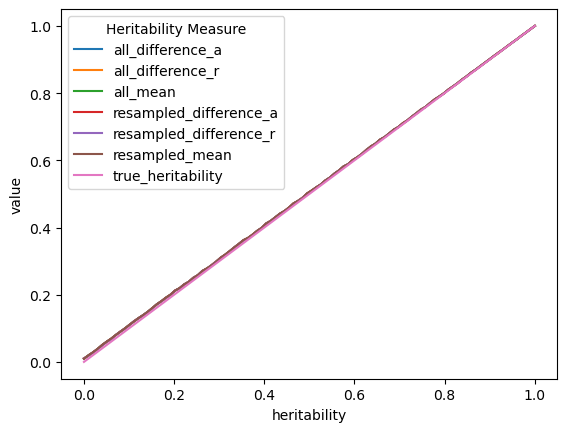

In [10]:
sns.lineplot(
    data=melt_df,
    x="heritability",
    y="value",
    hue="Heritability Measure",
    # linestyles="--",
)

In [11]:
# sns.catplot(
#     data=melt_df,
#     row="heritability",
#     y="value",
#     hue="Heritability Measure",
#     sharey=False,
# )

<Axes: xlabel='heritability', ylabel='abs_error'>

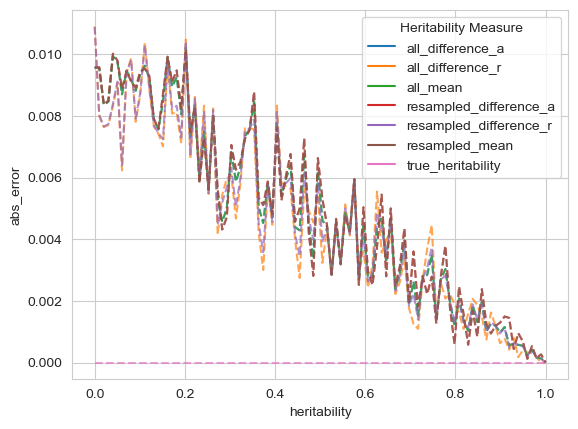

In [33]:
# Find closest on estimation method
melt_df['abs_error'] = np.abs(melt_df['heritability'] - melt_df['value'])

# Plot smoothed error by heritability and estimation method
sns.lineplot(
    data=melt_df,
    x="heritability",
    y="abs_error",
    hue="Heritability Measure",
    linestyle='--',
    alpha=0.7,
)

In [16]:
error_df = melt_df.groupby('Heritability Measure').mean().sort_values(
    'abs_error', ascending=True
)
error_df.rename(
    columns={'abs_error': 'mean absolute error'},
    inplace=True
)
error_df

,heritability,value,mean absolute error
Heritability Measure,,,
true_heritability,0.5,0.500000,0.000000
all_difference_r,0.5,0.504599,0.004608
resampled_difference_r,0.5,0.504673,0.004673
all_difference_a,0.5,0.504833,0.004833
all_mean,0.5,0.504833,0.004833
resampled_difference_a,0.5,0.504908,0.004908
resampled_mean,0.5,0.504908,0.004908


#### Look at how number of replicates, samples, and resamples affect the accuracy of the heritability estimate

In [18]:
from itertools import product

# Generate estimates for a range of heritabilities, n replicates,
# n samples, and n resamples.

n_herits = 5
n_samples_fracs = 3
n_rep = 3
n_resamp = 3
est_results = []

herits = np.linspace(0.0, 1.0, n_herits)
sample_fracs = np.linspace(0.1, 1.0, n_samples_fracs)
n_replicates = np.linspace(10, 5000, n_rep).astype(int)
n_resamples = np.linspace(10, 5000, n_resamp).astype(int)

for h2, n_samp_frac, n_rep, n_resamp in tqdm(
	product(herits, sample_fracs, n_replicates, n_resamples),
	total=n_herits * n_samples_fracs * n_rep * n_resamp
):
	est_h2 = estimate_heritability(
		PhenoSimulation(gen_config(heritability=h2)),
		copy.deepcopy(input_vals),
		n_replicates=n_rep,
		n_bootstrap=n_resamp,
		n_samples=n_samp_frac,
	)
	est_results.append(
		{
			"heritability": h2,
			"n_replicates": n_rep,
			"n_resamples": n_resamp,
			"n_samples_frac": n_samp_frac,
			**est_h2,
		}
	)

100%|██████████| 135/135 [10:30<00:00,  4.67s/it]


In [19]:
# Setup DataFrame
param_results_df = pd.DataFrame(est_results)
param_results_df['true_heritability'] = param_results_df['heritability']

pr_melt_df = param_results_df.melt(
    id_vars=['heritability', 'n_replicates', 'n_resamples', 'n_samples_frac'],
    value_vars=param_results_df.columns.tolist(),
    var_name='Heritability Measure',
    value_name='value'
)
pr_melt_df['error'] = pr_melt_df['value'] - pr_melt_df['heritability']
pr_melt_df

,heritability,n_replicates,n_resamples,n_samples_frac,Heritability Measure,value,error
0,0.0,10,10,0.1,all_difference_a,0.091868,0.091868
1,0.0,10,2505,0.1,all_difference_a,0.109676,0.109676
2,0.0,10,5000,0.1,all_difference_a,0.100144,0.100144
3,0.0,2505,10,0.1,all_difference_a,0.000382,0.000382
4,0.0,2505,2505,0.1,all_difference_a,0.000392,0.000392
...,...,...,...,...,...,...,...
940,1.0,2505,2505,1.0,true_heritability,1.000000,0.000000
941,1.0,2505,5000,1.0,true_heritability,1.000000,0.000000
942,1.0,5000,10,1.0,true_heritability,1.000000,0.000000
943,1.0,5000,2505,1.0,true_heritability,1.000000,0.000000


<Axes: xlabel='heritability', ylabel='error'>

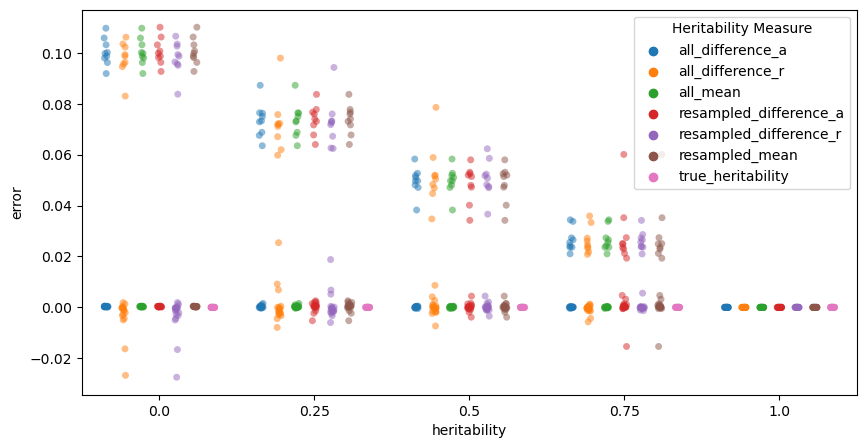

In [20]:
# Plot
plt.figure(figsize=(10, 5))
sns.stripplot(
    data=pr_melt_df,
    x='heritability',
    y='error',
    hue='Heritability Measure',
    dodge=True,
    alpha=0.5,
)

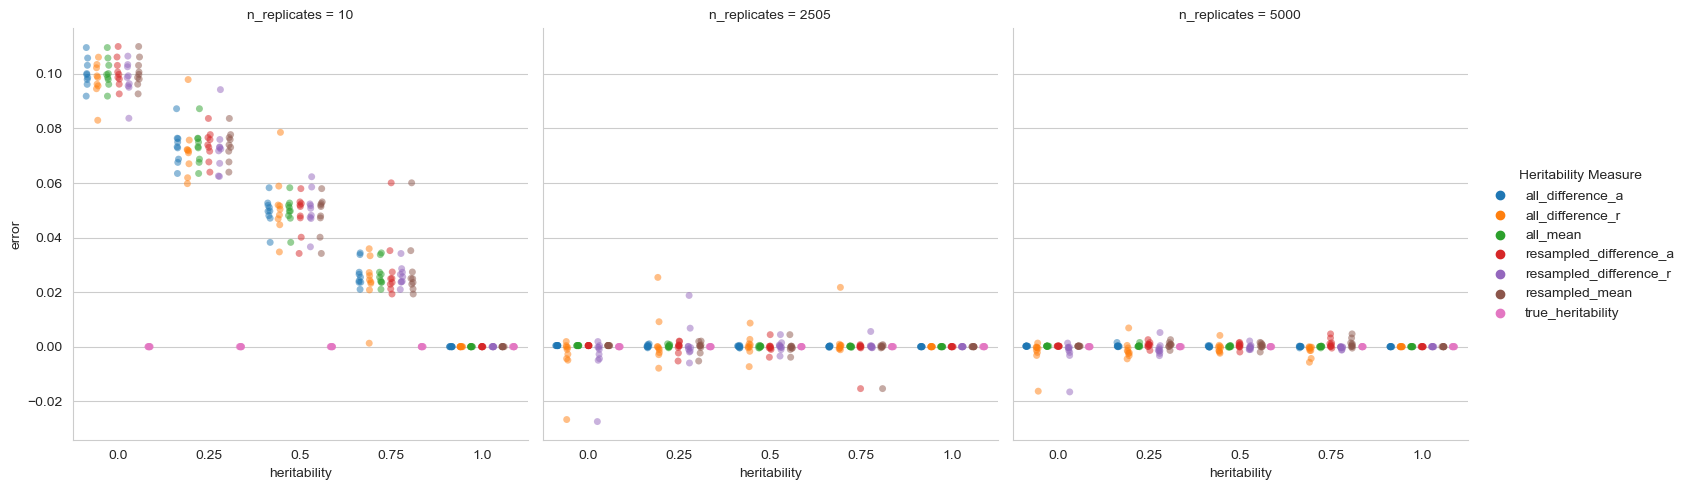

In [21]:
# Plot breaking out error by number of replicated generated per genotype
sns.set_style("whitegrid")
sns.catplot(
    data=pr_melt_df,
    x='heritability',
    y='error',
    hue='Heritability Measure',
    col='n_replicates',
    alpha=0.5,
    dodge=True,
)

Since performance is way worse when n_replicates=10, we'll remove that for the rest of the analysis.

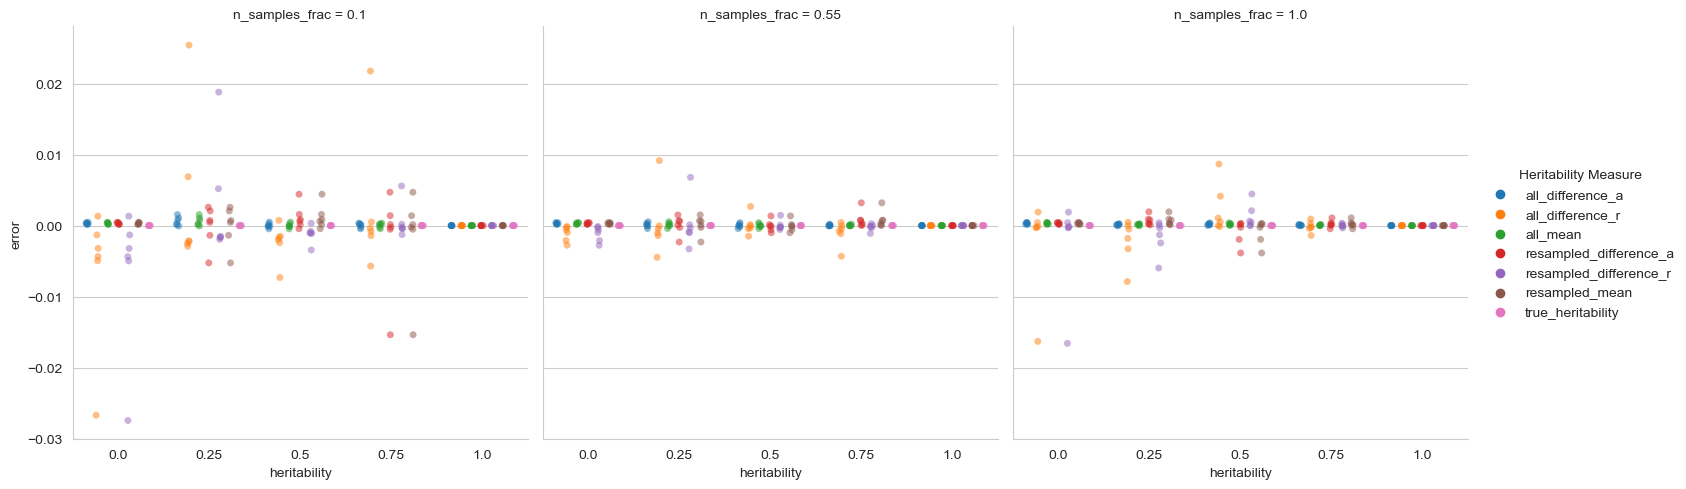

In [22]:
# Plot breaking out error by fraction of samples used in estimation
sns.set_style("whitegrid")
sns.catplot(
    data=pr_melt_df[pr_melt_df.n_replicates > 10],
    x='heritability',
    y='error',
    hue='Heritability Measure',
    col='n_samples_frac',
    alpha=0.5,
    dodge=True,
)

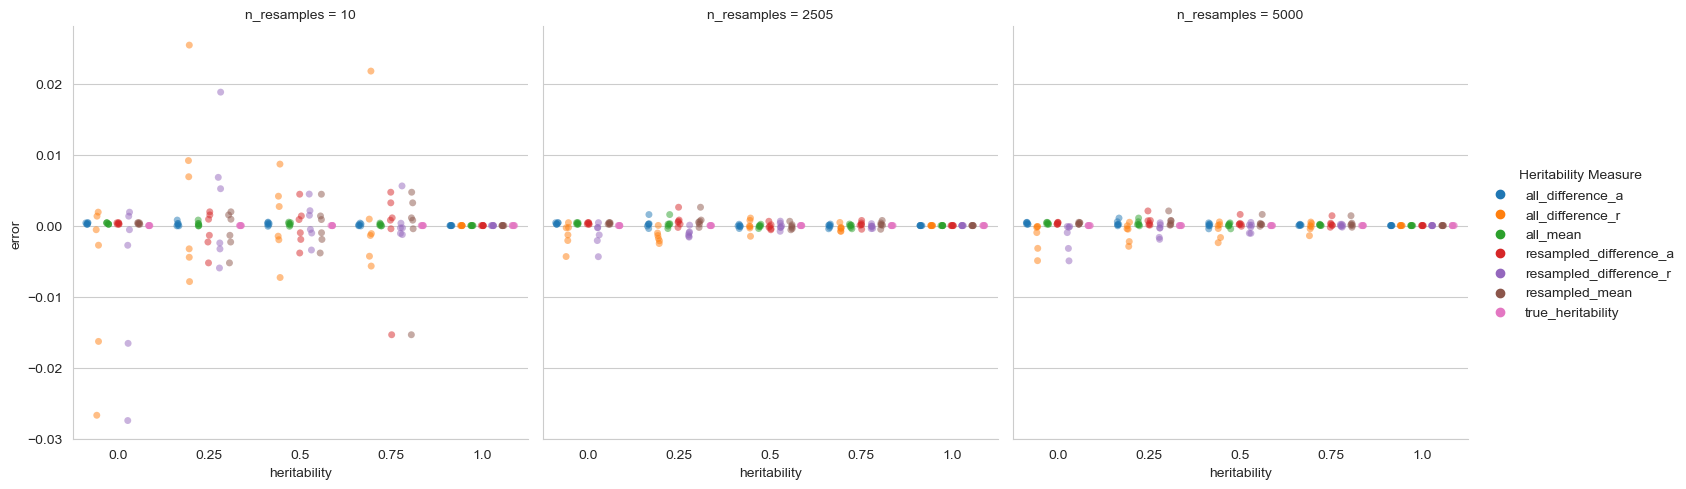

In [23]:
# Plot breaking out error by number resamples to estimate Var(P)
sns.set_style("whitegrid")
sns.catplot(
    data=pr_melt_df[pr_melt_df.n_replicates > 10],
    x='heritability',
    y='error',
    hue='Heritability Measure',
    col='n_resamples',
    alpha=0.5,
    dodge=True,
)

In [24]:
# Rank everything
ranking_df = pr_melt_df[pr_melt_df.n_replicates > 10]
ranking_df['abs_error'] = ranking_df['error'].abs()
ranking_df = ranking_df.groupby('Heritability Measure').mean().sort_values('abs_error')

/var/folders/nc/cys5vslx1vbdtfyjwk1q5slm0000gn/T/ipykernel_9743/584444881.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ranking_df['abs_error'] = ranking_df['error'].abs()


In [25]:
ranking_df

,heritability,n_replicates,n_resamples,n_samples_frac,value,error,abs_error
Heritability Measure,,,,,,,
true_heritability,0.5,3752.5,2505.0,0.55,0.500000,0.000000,0.000000
all_difference_a,0.5,3752.5,2505.0,0.55,0.500138,0.000138,0.000199
all_mean,0.5,3752.5,2505.0,0.55,0.500138,0.000138,0.000199
resampled_difference_a,0.5,3752.5,2505.0,0.55,0.500081,0.000081,0.000837
resampled_mean,0.5,3752.5,2505.0,0.55,0.500081,0.000081,0.000837
resampled_difference_r,0.5,3752.5,2505.0,0.55,0.499446,-0.000554,0.001689
all_difference_r,0.5,3752.5,2505.0,0.55,0.499532,-0.000468,0.002410


## Should also work with dominace inheritance patterns and other non-linearities 

In [26]:
def gen_config_dominance(heritability=1.0):
	"""Return linear additive model config with specified heritability."""
	return {
		"input": [
			{
				"file": "1000_genomes_data/ALL.chr19.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz",
				"file_format": "vcf",
				"reference_genome": "GRCh37",
				"force_bgz": True,
				"input_nodes": [
					{
						"alias": "rare_variants",
						"type": "SNP",
						"chr": "19",
						"pos": [13397324, 52901080, 16023111]
					},
					{
						"alias": "common_variants",
						"type": "SNP",
						"chr": "19",
						"pos": [55555845, 55261043, 45857820, 55442280, 39369369]
					}
				]
			}
		],
		"simulation_steps": [
			{
				"type": "RandomConstant",
				"alias": "rare_variants_betas",
				"input_match_size": "rare_variants",
				"dist_name": "normal",
				"dist_kwargs": {
					"loc": 0.0,
					"scale": 0.5
				},
				"by_feat": True
			},
			{
				"type": "RandomConstant",
				"alias": "common_variants_betas",
				"input_match_size": "common_variants",
				"dist_name": "normal",
				"dist_kwargs": {
					"loc": 0.0,
					"scale": 0.2
				},
				"by_feat": True
			},
			{
				"type": "Product",
				"alias": "rare_variant_effects",
				"input_aliases": [
					"rare_variants_betas", "rare_variants"
				]
			},
			{
				"type": "Product",
				"alias": "common_variant_effects",
				"input_aliases": [
					"common_variants_betas", "common_variants"
				]
			},
			{
				"type": "Concatenate",
				"alias": "variant_effects",
				"input_aliases": [
					"rare_variant_effects", "common_variant_effects"
				],
			},
			{
				"type": "MaxCombine",
				"alias": "combined_variant_effects",
				"input_alias": "variant_effects"
			},
			{
				"type": "SumReduce",
				"alias": "no_noise_phenotype",
				"input_alias": "combined_variant_effects"
			},
			{
				"type": "Heritability",
				"alias": "phenotype",
				"input_alias": "no_noise_phenotype",
				"heritability": heritability
			}
		]
	}


In [27]:
# Generate estimates for a range of heritabilities

n_herits = 10
est_results = []

for h2 in tqdm(np.linspace(0.0, 1.0, n_herits)):
    est_h2 = estimate_heritability(
        PhenoSimulation(gen_config_dominance(heritability=h2)),
        copy.deepcopy(input_vals),
	)
    est_results.append({
        "heritability": h2,
        **est_h2,
    })
    
df = pd.DataFrame(est_results)
df

100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


,heritability,all_difference_a,all_difference_r,all_mean,resampled_difference_a,resampled_difference_r,resampled_mean
0,0.000000,0.009874,0.008154,0.009874,0.009891,0.008168,0.009891
1,0.111111,0.118336,0.116621,0.118336,0.118540,0.116822,0.118540
2,0.222222,0.231603,0.230712,0.231603,0.231810,0.230918,0.231810
3,0.333333,0.338116,0.338190,0.338116,0.338091,0.338165,0.338091
4,0.444444,0.450667,0.451213,0.450667,0.450422,0.450967,0.450422
5,0.555556,0.561053,0.560057,0.561053,0.561612,0.560615,0.561612
6,0.666667,0.669582,0.669459,0.669582,0.669664,0.669541,0.669664
7,0.777778,0.780287,0.780600,0.780287,0.780043,0.780356,0.780043
8,0.888889,0.890149,0.889689,0.890149,0.890557,0.890098,0.890557
9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
df['true_heritability'] = df['heritability']

df = df.melt(
    id_vars=['heritability'],
    value_vars=df.columns.tolist(),
    var_name='Heritability Measure',
    value_name='value',
)

<Axes: xlabel='heritability', ylabel='error'>

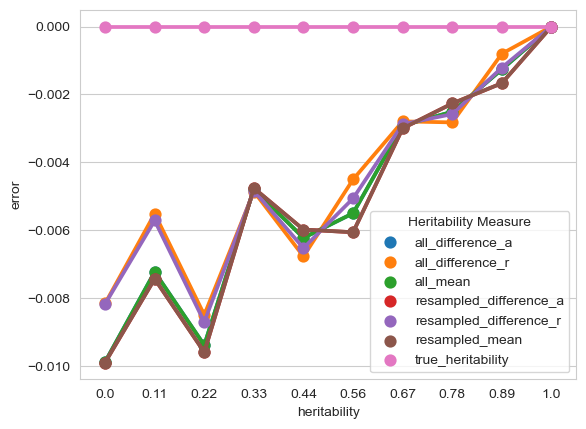

In [29]:
from matplotlib.ticker import StrMethodFormatter

# Find closest on estimation method
df['error'] = df['heritability'] - df['value']

# Plot smoothed error by heritability and estimation method
sns.pointplot(
    data=df,
    x=df.heritability.apply(lambda x: round(x, 2)),
    y="error",
    hue="Heritability Measure",
)

In [30]:
df['abs_error'] = np.abs(df['error'])
error_df = df.groupby('Heritability Measure').mean().sort_values(
    'abs_error', ascending=True
)
error_df.rename(
    columns={'abs_error': 'mean absolute error'},
    inplace=True
)
error_df

,heritability,value,error,mean absolute error
Heritability Measure,,,,
true_heritability,0.5,0.500000,0.000000,0.000000
all_difference_r,0.5,0.504470,-0.004470,0.004470
resampled_difference_r,0.5,0.504565,-0.004565,0.004565
all_difference_a,0.5,0.504967,-0.004967,0.004967
all_mean,0.5,0.504967,-0.004967,0.004967
resampled_mean,0.5,0.505063,-0.005063,0.005063
resampled_difference_a,0.5,0.505063,-0.005063,0.005063
